In [1]:
from google.colab import files

uploaded = files.upload()


Saving sales_data_sample.csv to sales_data_sample.csv


# **Load and Inspect Data**

In [5]:
import pandas as pd
df = pd.read_csv('sales_data_sample.csv', encoding='latin1') ##encoded using latin1
df.head()


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


# **Preprocess the Data**

In [10]:
df = df[['ORDERDATE', 'SALES']]
# Rename columns for Prophet
df.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'}, inplace=True)

# Convert date to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Sort by date
df = df.sort_values(by='ds')
df.head()


<ipython-input-10-60a431cdf9db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'}, inplace=True)
<ipython-input-10-60a431cdf9db>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = pd.to_datetime(df['ds'])


,ds,y
578,2003-01-06,5151.00
680,2003-01-06,3390.00
1267,2003-01-06,1903.22
2024,2003-01-06,1689.03
1539,2003-01-09,1404.00


# **Install and Import Prophet**

In [11]:
!pip install prophet

from prophet import Prophet


# **Fit the Forecasting Model**

In [12]:
model = Prophet()
model.fit(df)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5q3gr310/2ajf662q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5q3gr310/uxvfla6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81946', 'data', 'file=/tmp/tmp5q3gr310/2ajf662q.json', 'init=/tmp/tmp5q3gr310/uxvfla6o.json', 'output', 'file=/tmp/tmp5q3gr310/prophet_modelptcbiy10/prophet_model-20250527050158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:01:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:01:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# **Make Future Predictions**

In [13]:
future = model.make_future_dataframe(periods=90)  # 90 days into future
forecast = model.predict(future)


# **Visualize the Forecast**

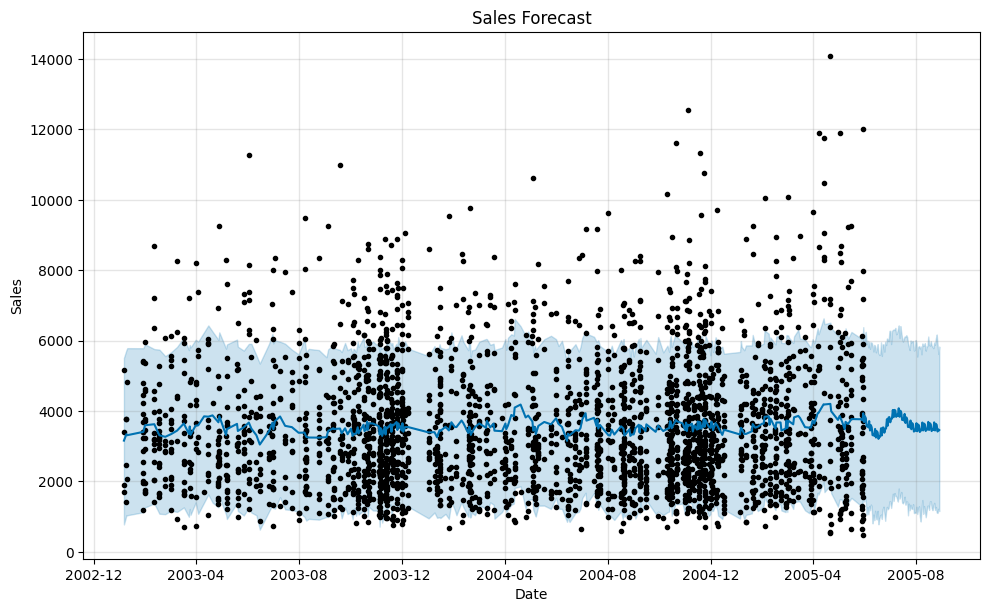

In [14]:
import matplotlib.pyplot as plt

# Plot the forecast
model.plot(forecast)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


# **Visualize Trend and Seasonality**

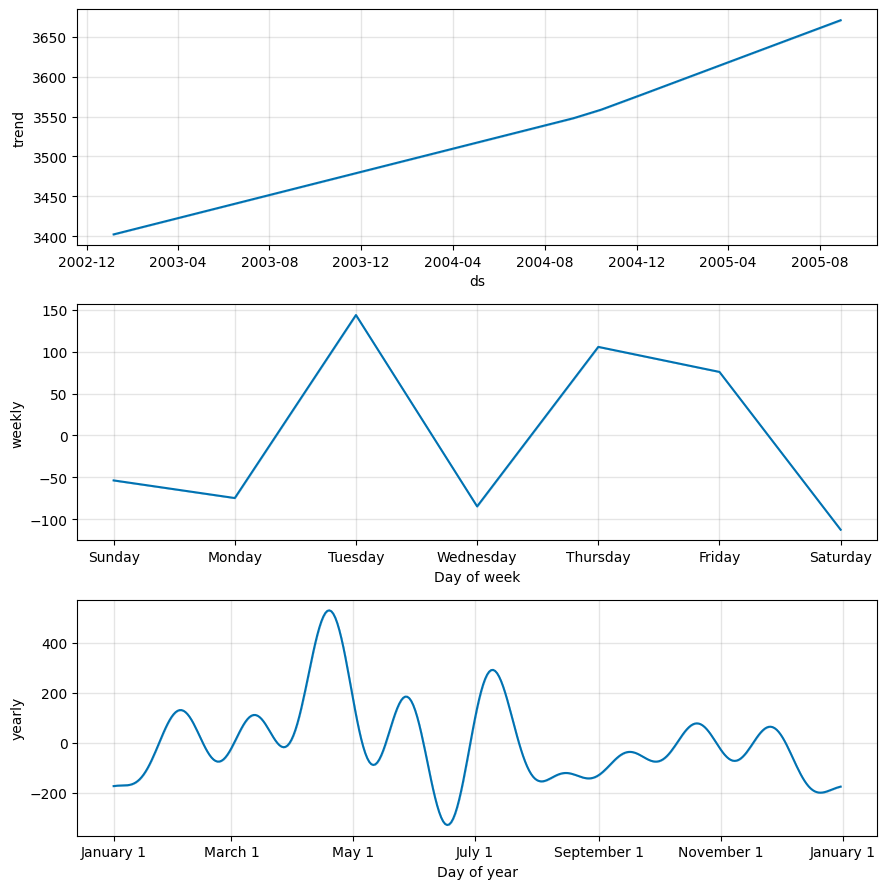

In [15]:
model.plot_components(forecast)
plt.show()


# **Evaluate Forecast Accuracy**

In [16]:
from sklearn.metrics import mean_absolute_error

# Compare predicted vs actuals for known period
predicted = forecast.set_index('ds').loc[df['ds']]
actual = df.set_index('ds')

mae = mean_absolute_error(actual['y'], predicted['yhat'])
print(f'Mean Absolute Error: {mae:.2f}')


Mean Absolute Error: 1427.77


# **Scikit-Learn More Accuracy Metrics**

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming 'actual' and 'predicted' are aligned Pandas Series from earlier

mse = mean_squared_error(actual['y'], predicted['yhat'])
rmse = np.sqrt(mse)
r2 = r2_score(actual['y'], predicted['yhat'])

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.2f}')


Mean Absolute Error (MAE): 1427.77
Mean Squared Error (MSE): 3362573.07
Root Mean Squared Error (RMSE): 1833.73
R-squared (R2): 0.01


# *Sales Forecasting Using Scikit-learn Regression*

In [19]:
df_reg = df.copy()
df_reg = df_reg.reset_index(drop=True)

# Create a time index feature
df_reg['time_idx'] = range(len(df_reg))

# Create lag features (e.g., sales 1 day ago)
df_reg['lag_1'] = df_reg['y'].shift(1)

# Rolling mean for last 7 days
df_reg['rolling_mean_7'] = df_reg['y'].rolling(window=7).mean()

# Drop rows with NaN values due to lag/rolling
df_reg = df_reg.dropna()

df_reg.head()


,ds,y,time_idx,lag_1,rolling_mean_7
6,2003-01-09,3782.00,6,2472.96,2827.458571
7,2003-01-09,3773.38,7,3782.00,2630.655714
8,2003-01-10,2055.74,8,3773.38,2440.047143
9,2003-01-10,4808.31,9,2055.74,2855.060000
10,2003-01-29,4228.20,10,4808.31,3217.798571


# *Split Train/Test Data*

In [20]:
from sklearn.model_selection import train_test_split

features = ['time_idx', 'lag_1', 'rolling_mean_7']
X = df_reg[features]
y = df_reg['y']

# Split 80% train, 20% test preserving order (no shuffle)
train_size = int(len(df_reg) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# *Train a Regression Model (Random Forest as example)*

In [21]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

# *Predict and Evaluate*

In [22]:
y_pred = model_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred)
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print(f'Random Forest Regression - MAE: {mae_rf:.2f}')
print(f'Random Forest Regression - RMSE: {rmse_rf:.2f}')
print(f'Random Forest Regression - R2: {r2_rf:.2f}')


Random Forest Regression - MAE: 1526.39
Random Forest Regression - RMSE: 1949.22
Random Forest Regression - R2: 0.12


# *Visualize Actual vs Predicted*

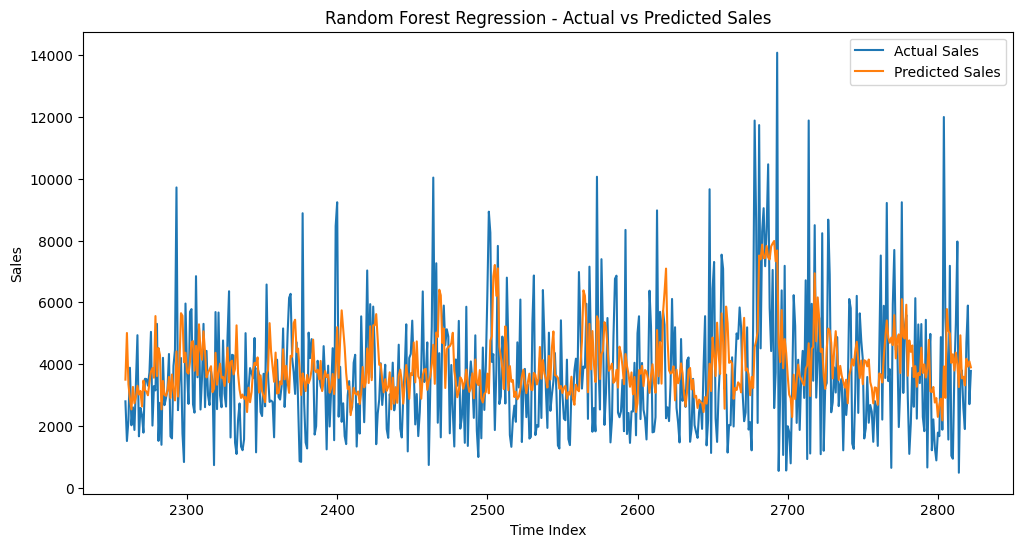

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales')
plt.title('Random Forest Regression - Actual vs Predicted Sales')
plt.xlabel('Time Index')
plt.ylabel('Sales')
plt.legend()
plt.show()


# **Hyperparameter Tuning with GridSearchCV**

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


# *Define the Parameter Grid*

In [25]:
param_grid = {
    'n_estimators': [50, 100, 200],         # Number of trees
    'max_depth': [None, 10, 20, 30],        # Max depth of trees
    'min_samples_split': [2, 5, 10],        # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'] # Number of features considered for splitting
}


# *Initialize the Model and GridSearchCV*

In [26]:
rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,                # 3-fold cross-validation
                           n_jobs=-1,           # Use all CPU cores
                           scoring='neg_mean_absolute_error',
                           verbose=2)


# *Fit GridSearch to Training Data*

In [27]:
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_absolute_error', verbose=2)

# *Check Best Parameters and Score*

In [28]:
print("Best parameters found:", grid_search.best_params_)
print("Best MAE (negative):", grid_search.best_score_)


Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best MAE (negative): -1314.5835679068714


# *Evaluate Best Estimator on Test Data*

In [29]:
best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Tuned Random Forest - MAE: {mae_best:.2f}")
print(f"Tuned Random Forest - RMSE: {rmse_best:.2f}")
print(f"Tuned Random Forest - R2: {r2_best:.2f}")


Tuned Random Forest - MAE: 1507.44
Tuned Random Forest - RMSE: 1941.92
Tuned Random Forest - R2: 0.12


# *Visualize Tuned Model Predictions*

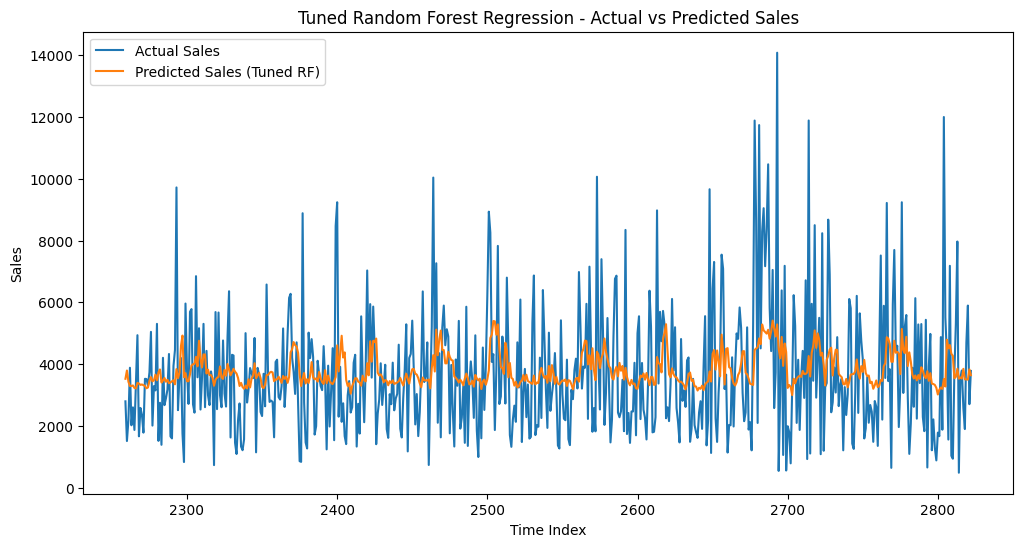

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual Sales')
plt.plot(y_test.index, y_pred_best, label='Predicted Sales (Tuned RF)')
plt.title('Tuned Random Forest Regression - Actual vs Predicted Sales')
plt.xlabel('Time Index')
plt.ylabel('Sales')
plt.legend()
plt.show()


# ***Accuracy of Default Random Forest***

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train default RF
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Predict
y_pred_rf = model_rf.predict(X_test)

# Accuracy metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("▶ Default Random Forest")
print(f"MAE  : {mae_rf:.2f}")
print(f"RMSE : {rmse_rf:.2f}")
print(f"R²    : {r2_rf:.2f}")


▶ Default Random Forest
MAE  : 1526.39
RMSE : 1949.22
R²    : 0.12


# ***Accuracy of Tuned Random Forest***

 Lower MAE and RMSE and higher R² means the tuned model performs better.

In [32]:
# Predict with tuned model
y_pred_best = best_rf.predict(X_test)

# Accuracy metrics
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("\n▶ Tuned Random Forest")
print(f"MAE  : {mae_best:.2f}")
print(f"RMSE : {rmse_best:.2f}")
print(f"R²    : {r2_best:.2f}")



▶ Tuned Random Forest
MAE  : 1507.44
RMSE : 1941.92
R²    : 0.12
